In [1]:
import numpy as np
import SimpleITK as sitk
import os
import pydicom as dicom
import matplotlib.pyplot as plt
import gui 
%matplotlib notebook

In [3]:
data_directory = "/home/share/rochester_CT/HTC_Lungmap_D116_anonymized_RightLung/Localizers/AX BONE .67 - 5/"
# Get the list of files belonging to a specific series ID.
reader = sitk.ImageSeriesReader()
# Use the functional interface to read the image series.
img_D116 = sitk.ReadImage(reader.GetGDCMSeriesFileNames(data_directory))

<IPython.core.display.Javascript object>


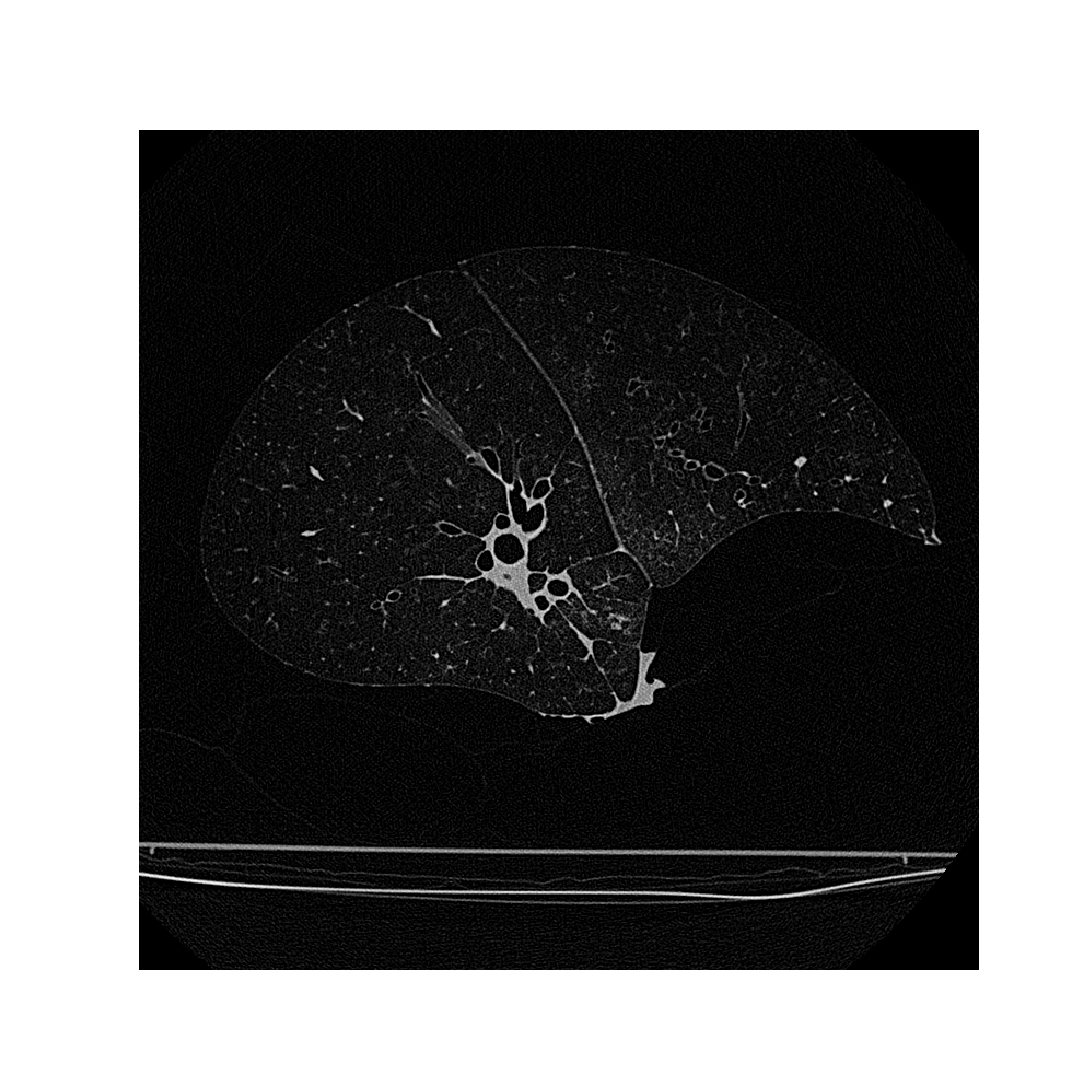

In [4]:
def plot_img(img, s):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(sitk.GetArrayViewFromImage(img)[s,:,:], cmap=plt.cm.Greys_r)
    plt.axis('off');

plot_img(img_D116, 400)

In [4]:
denoised_list = list()
for i in [0.001, 0.005, 0.01]:
    for j in [10, 20, 30]:
        imdenoise = sitk.CurvatureFlow(image1=img_D116,
                   timeStep=i,
                   numberOfIterations=j) 
        denoised_list.append(imdenoise)

In [11]:
def show_images(images, s, cols = 1, titles = None, save = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=(6,6))
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(sitk.GetArrayViewFromImage(image)[s,:,:], cmap=plt.cm.Greys_r)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    if save is not None: fig.savefig(save)

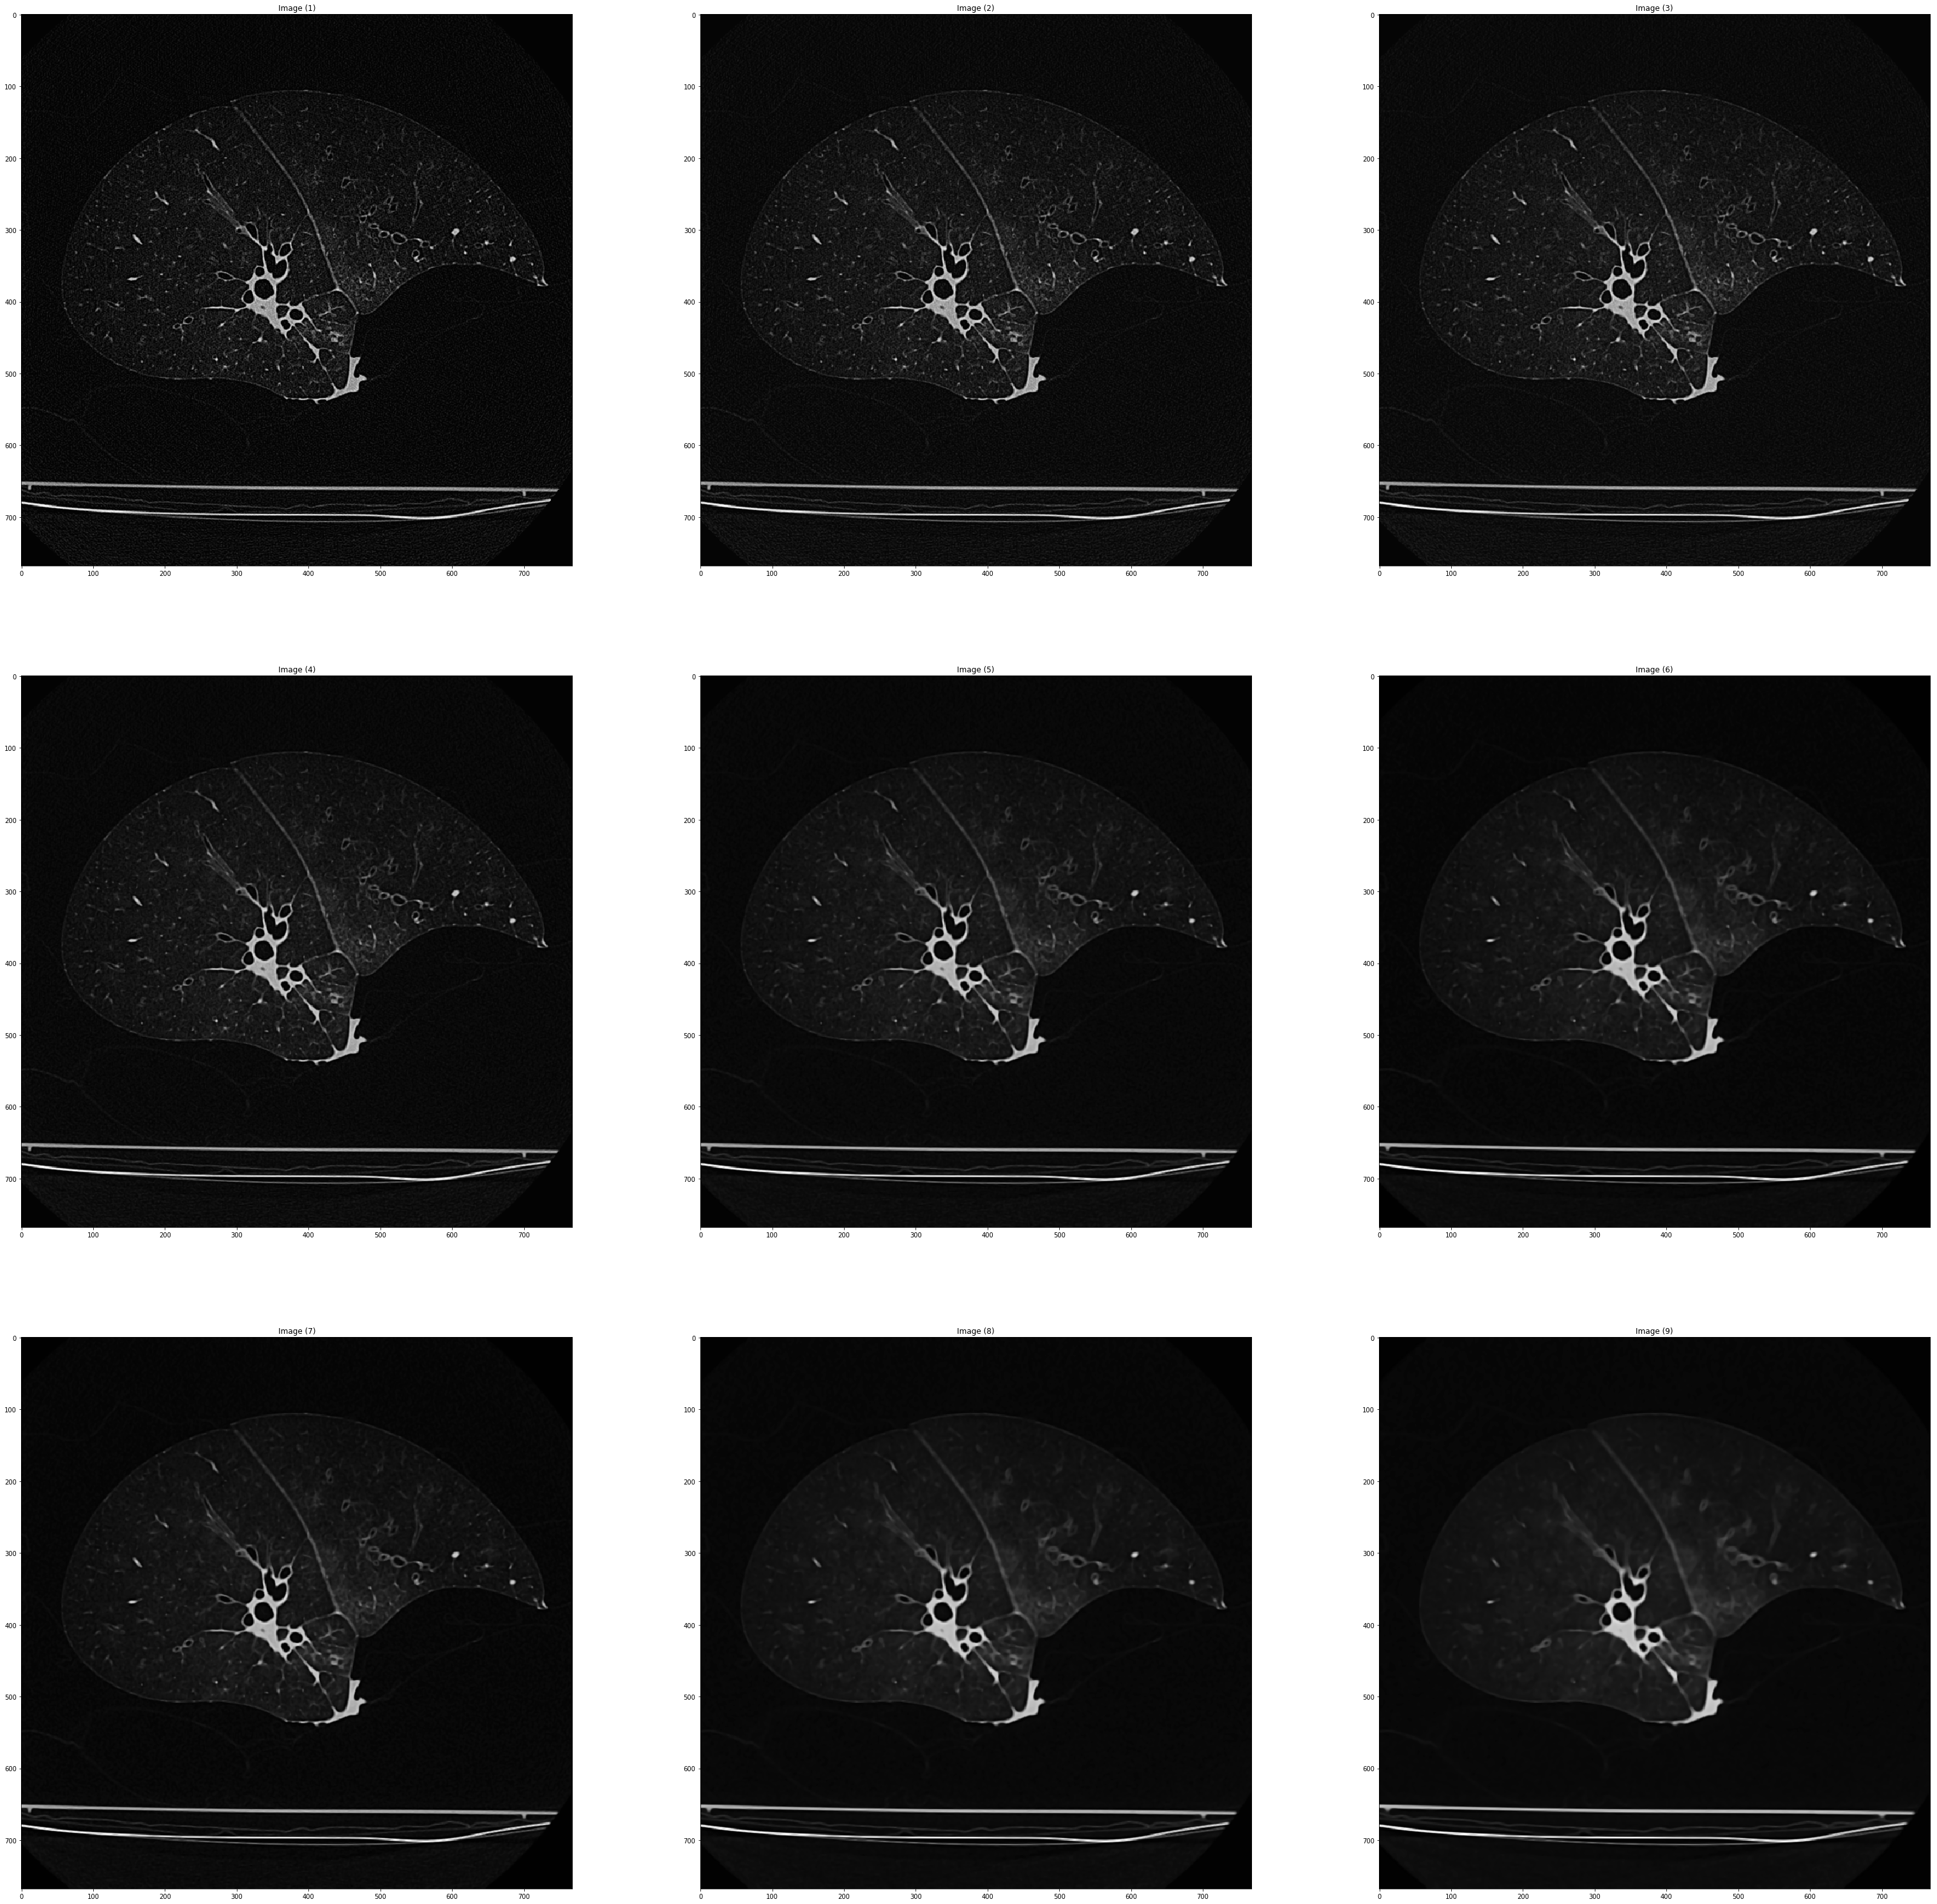

In [14]:
show_images(denoised_list[0:9], 400, cols = 3, save = "figs/denoise_test.pdf")

<IPython.core.display.Javascript object>


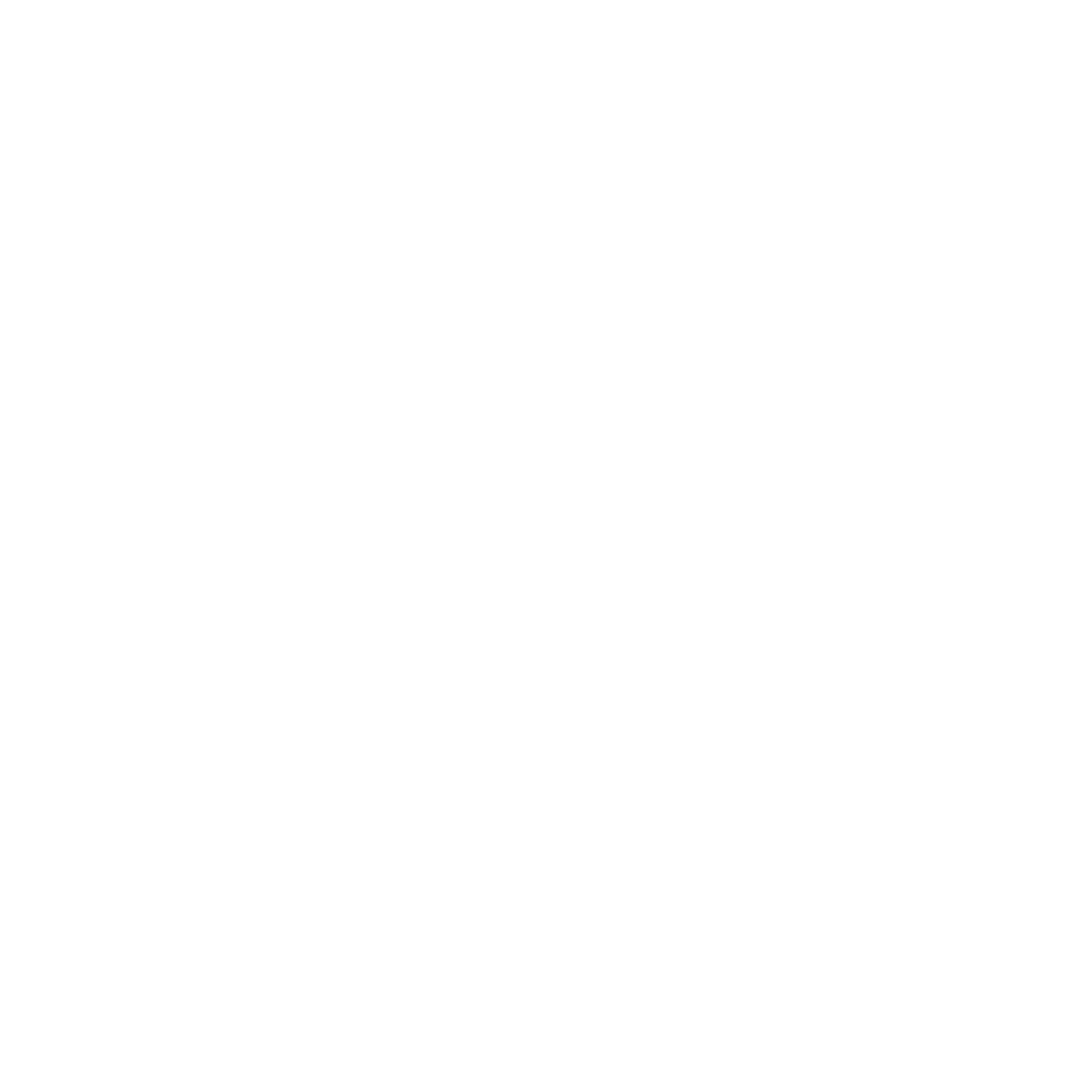

In [27]:
imdenoise = sitk.CurvatureFlow(image1=img_D116,
           timeStep=0.01,
           numberOfIterations=30)
img_D116_smooth = imdenoise
plot_img(img_D116_smooth, 400)

In [28]:
output_file = "/home/butlera/Projects/HuBMAP/processed/D116_smooth.mha"
sitk.WriteImage(img_D116_smooth, output_file)

In [1]:
import numpy as np
import SimpleITK as sitk
import os
import pydicom as dicom
import matplotlib.pyplot as plt
import gui 
%matplotlib notebook
output_file = "/home/butlera/Projects/HuBMAP/processed/D116_smooth.mha"
img_D116_smooth = sitk.ReadImage(output_file)

<IPython.core.display.Javascript object>


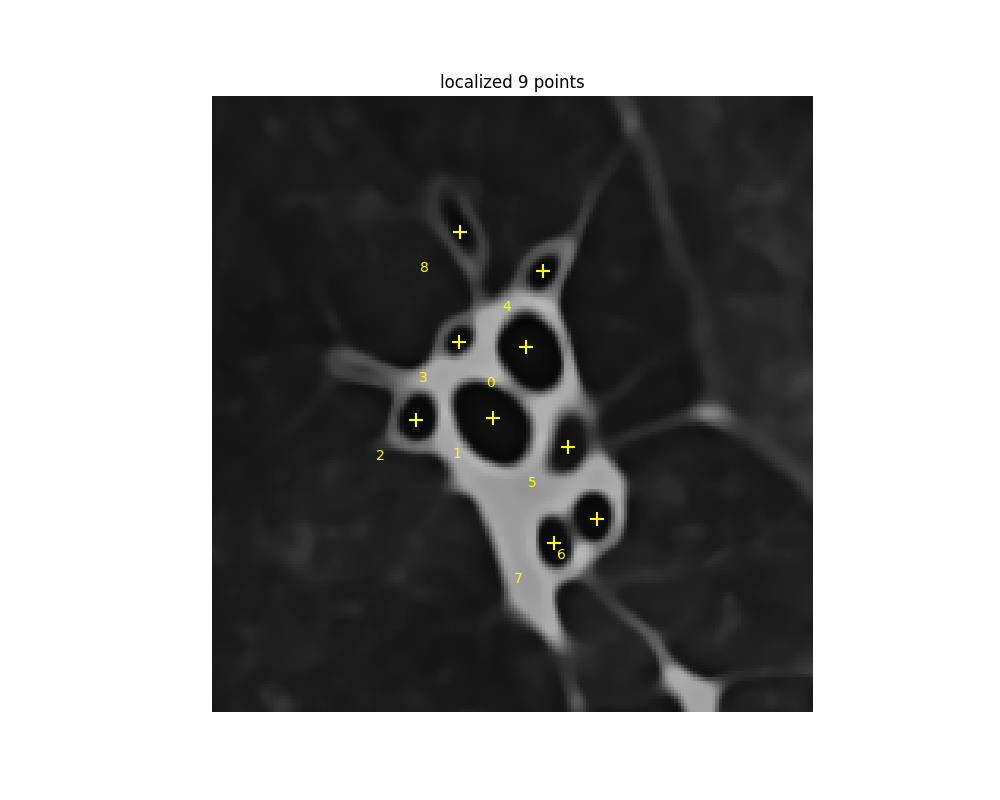

In [2]:
import gui 
%matplotlib notebook
point_acquisition_interface = gui.PointDataAquisition(img_D116_smooth)

In [3]:
initial_seed_point_indexes = point_acquisition_interface.get_point_indexes()

In [4]:
seg_implicit_thresholds = sitk.ConfidenceConnected(
    img_D116_smooth,
    seedList=initial_seed_point_indexes,
    numberOfIterations=1,
    multiplier=2.5,
    initialNeighborhoodRadius=1,
    replaceValue=1
)

<IPython.core.display.Javascript object>


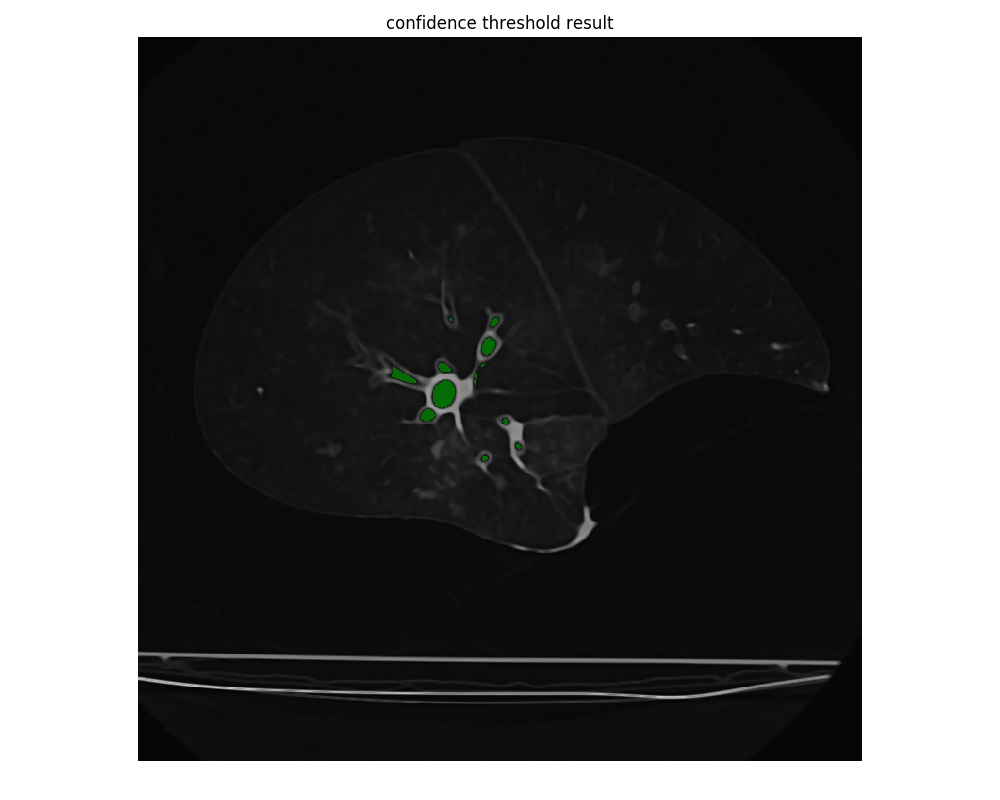

In [5]:
img_int = sitk.Cast(sitk.RescaleIntensity(img_D116_smooth), seg_implicit_thresholds.GetPixelID())
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(img_int, seg_implicit_thresholds)],                   
                      title_list = ['confidence threshold result'])

In [7]:
vectorRadius=(1,1,1)
kernel=sitk.sitkBall

seg_implicit_thresholds_clean = sitk.BinaryMorphologicalClosing(seg_implicit_thresholds, 
                                                                vectorRadius,
                                                                kernel)

<IPython.core.display.Javascript object>


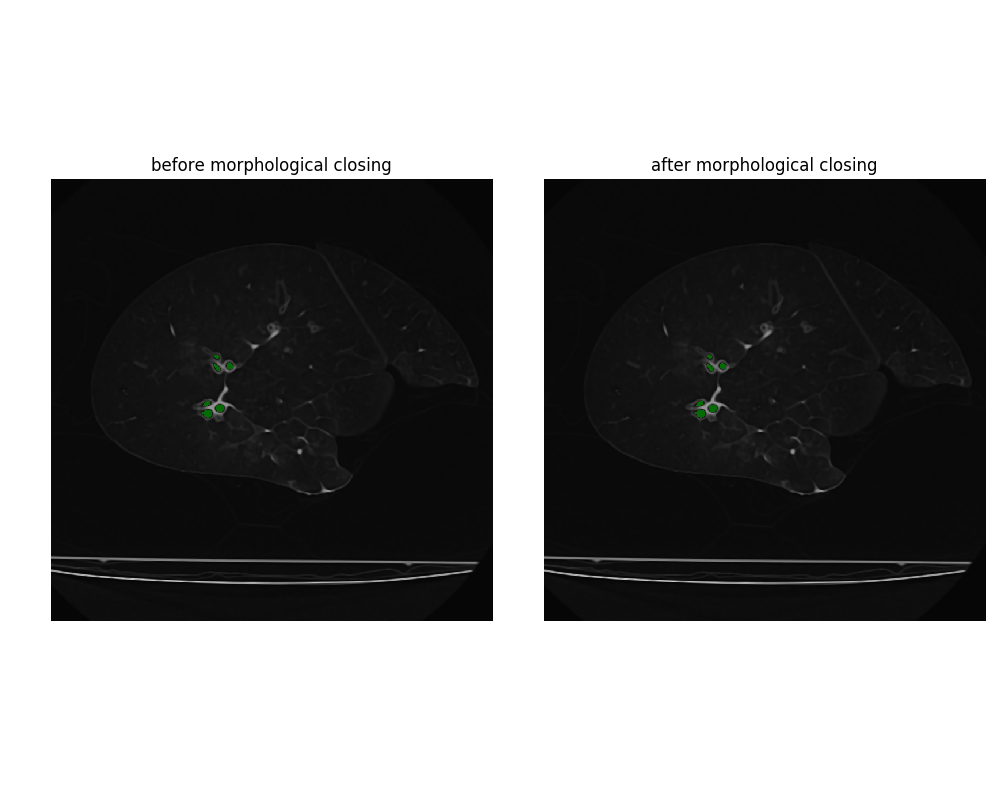

In [8]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(img_int, seg_implicit_thresholds), 
                                sitk.LabelOverlay(img_int, seg_implicit_thresholds_clean)], 
                  shared_slider=True,
                  title_list = ['before morphological closing', 'after morphological closing'])

Morphological closing doesn't seem to do much if the segmentation is already decent. If it's really overblown though, it can help bring it back.

In [40]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize

def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, None, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(250, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(100, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()

Transposing surface
Calculating surface
Drawing


<IPython.core.display.Javascript object>


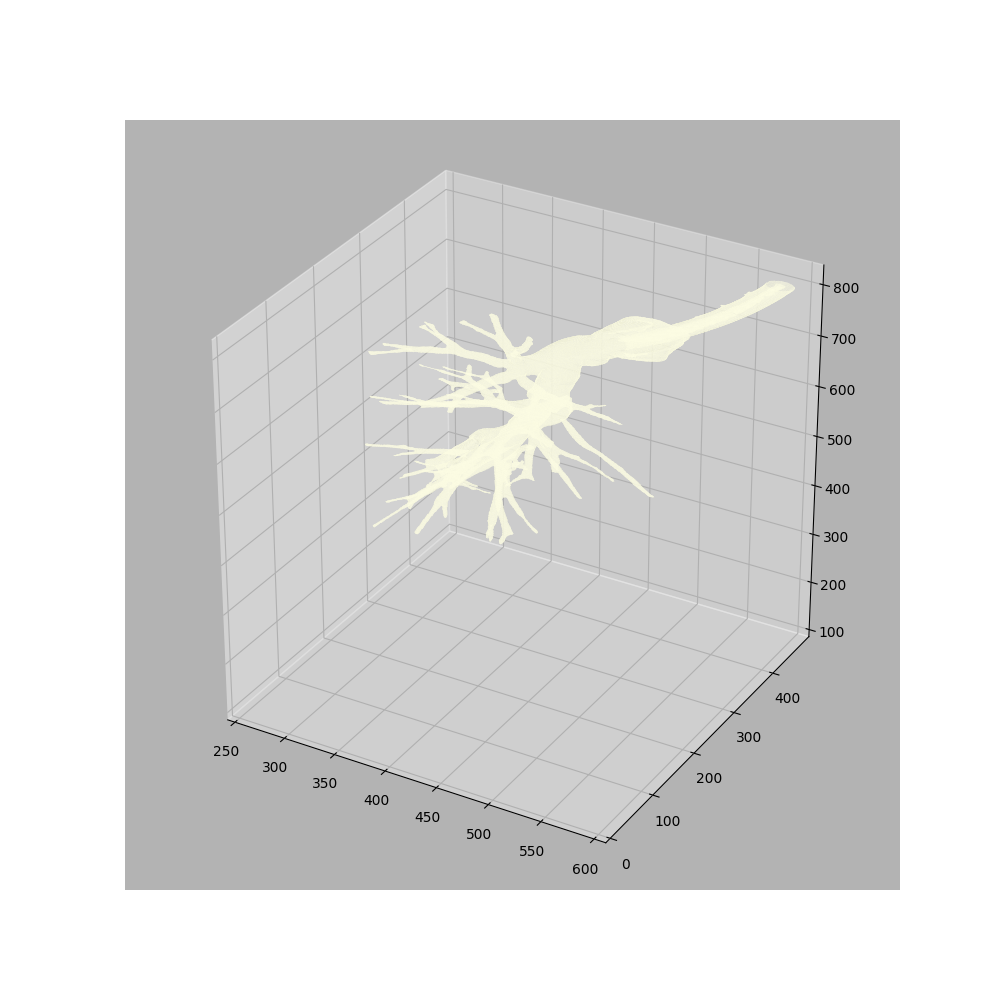

In [41]:
v, f = make_mesh(sitk.GetArrayViewFromImage(seg_implicit_thresholds_clean), 0)
plt_3d(v, f)

In [28]:
import vtk
from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

VTK might work better for plotting but seems to hard to use/poorly documented.
Some hints here: https://pyscience.wordpress.com/2014/09/03/ipython-notebook-vtk/